### Stock Forecasting - Amazon Stock Data

In this notebook we are going to build a model using pytorch that does stock forecasting using the amaxon data. The data that we will be using will be found in the `AMZN.csv` file.

### Imports

First we are going to import all the packages that we are going to use in this notebook.


In [1]:

import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from helperfns.tables import tabulate_data
from helperfns.utils import hms_string
from copy import deepcopy as dc
from sklearn.model_selection import train_test_split

print("Numpy: ", np.__version__)
print("Torch: ", torch.__version__)

Numpy:  1.26.4
Torch:  2.2.2


### Seed
Next we are going to set the seed to be `23` for reproducivity in this notebook.

In [2]:
SEED = 23
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device
Next we are going to get the device to be `GPU` if we have GPU access.

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Loading the Data

The next step wa re going to load the data from our `csv` file.

In [4]:
dataframe = pd.read_csv('AMZN.csv')
dataframe.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000


From the above dataframe we are intrested in two columns which are the `Date` and `Close`. So we will be predicting the `Close` value based on the previous observed values over time.

In [5]:
dataframe = dataframe[["Date", "Close"]]
dataframe.head(2)

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458


Next we are going change the `Date` column to be of type pandas date using the `pd.to_datetime()` function.

In [6]:
dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe.head(2)

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458


Next let's plot the date aganist it's close value, and see what it actually looks like.

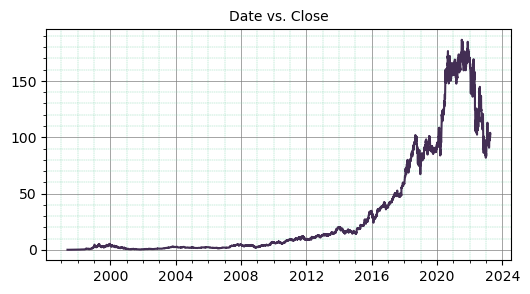

In [7]:
plt.figure(figsize=(6, 3))
plt.plot(dataframe.Date.values, dataframe.Close.values, color="#432E54")
plt.title("Date vs. Close", fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Data Preparation

For the data preparation on the `Close` value, we want to make sure that we get the previous history in order to predict the current `Close` value. For that we are going to create a function that will take in a dataframe and generate new columns on our data depending on how many days we want to be used as history. Here is what we will do it:


In [8]:
def prepare_dataframe_for_lstm(dataframe, lookback = 7):
    dataframe = dc(dataframe)
    dataframe.set_index('Date', inplace=True)
    for i in range(1, lookback + 1):
        dataframe[f'(t-{i})'] = dataframe['Close'].shift(i)
    dataframe.dropna(inplace=True)
    return dataframe

lookback = 7
shifted_df = prepare_dataframe_for_lstm(dataframe, lookback)
shifted_df.head(2)

,Close,(t-1),(t-2),(t-3),(t-4),(t-5),(t-6),(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458


Next we are going to convert our `Close` value and the previous close values `(t-1) - (t-7)` to become numpy arrays from a pandas dataframe.

In [9]:
data = shifted_df.to_numpy()
data.shape

(6509, 8)

Next we are going to scale the `Close` value and the previous close values using a `MinMaxScaler` so that they will have values between `-1` and `1`.

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)
scaled_data.shape

(6509, 8)

In the following code cell we are then going to extract the features which and labels.

In [11]:
X = scaled_data[:, 1:]
y = scaled_data[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

### Data Splits

Next we are going to take `95%` of our data and put it to the train and the remaining `5%` will be for the testing set. Again from the `95%` we are going to take another `5%` and put it to the validation data.

In [12]:
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.05, shuffle=False) ## this is a time series prediction
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, shuffle=False) ## this is a time series prediction

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((5873, 7), (5873,), (326, 7), (326,), (310, 7), (310,))

In [13]:
columns = ["Set", "Total"]
_data = [
    ["TRAINING", f"{len(X_train):,}"],
    ["TESTING", f"{len(X_test):,}"],
    ["VALIDATION", f"{len(X_val):,}"],
    ["TOTAL", f"{len(X_train) + len(X_test) + len(X_val):,}"],
]
tabulate_data(columns, _data, title="SETS EXAMPLES")

SETS EXAMPLES
+------------+-------+
| Set        | Total |
+------------+-------+
| TRAINING   | 5,873 |
| TESTING    |   326 |
| VALIDATION |   310 |
| TOTAL      | 6,509 |
+------------+-------+


Next we are going to reshape our `features` and `labels` in a way `LSTM` expect data to be.

In [14]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
X_val = X_val.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((5873, 7, 1), (5873, 1), (326, 7, 1), (326, 1), (310, 7, 1), (310, 1))

In [15]:
print(X_train[0])
print(y_train[0])

[[-0.99995531]
 [-1.        ]
 [-0.99998325]
 [-0.99987154]
 [-0.99983244]
 [-0.99982128]
 [-0.99969839]]
[-0.99991063]


Next we are going to convert our numpy arrays to `float` tensors.

In [16]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

X_val = torch.from_numpy(X_val).float()
y_val = torch.tensor(y_val).float()


### Dataset

Next we are going to create a `TimeSeriesDataset` dataset class that will take our features and give us a dataset object that we can batch later on.

In [17]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        super(TimeSeriesDataset, self).__init__()
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.y[index], self.X[index]

In [18]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val, y_val)

Next we are going to batch our data, we are going to set the batchsize to be `16`. We are going to turn on the shuffle of the train dataset only.

In [19]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

We can check the features and labels in the first batch of the training data.

In [20]:
for batch in train_loader: break

In [21]:
batch[0]

tensor([[-0.8276],
        [-0.9715],
        [-0.9816],
        [-0.9493],
        [-0.8993],
        [-0.9934],
        [-0.9555],
        [-0.9374],
        [-0.9885],
        [-0.5867],
        [-0.8770],
        [-0.9966],
        [-0.9761],
        [-0.9996],
        [-0.9554],
        [ 0.0017]])

In [22]:
batch[1][0]

tensor([[-0.8219],
        [-0.8174],
        [-0.8168],
        [-0.8204],
        [-0.8194],
        [-0.8193],
        [-0.8166]])

### Model

Next we are going to build our `LSTM` model.

In [23]:

class TimeSeriesBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.5, bidirectional=True):
        super(TimeSeriesBiLSTM, self).__init__()
    
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.out = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        self.dropout = nn.Dropout(dropout/3)

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device
        h0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, 
                         batch_size, 
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, 
                         batch_size, 
                         self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.out(out[:, -1, :])
        return out
        
INPUT_DIM = 1
HIDDEN_DIM = 16
OUTPUT_DIM = 1 
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.75

model = TimeSeriesBiLSTM(
    INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, 
    num_layers = N_LAYERS, 
    bidirectional = BIDIRECTIONAL, 
    dropout = DROPOUT
).to(device)
model


TimeSeriesBiLSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True, dropout=0.75, bidirectional=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Next we are going to count the model parameters. 

In [24]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["model", *count_trainable_params(model)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+-------+--------------+------------------+
| MODEL | TOTAL PARAMS | TRAINABLE PARAMS |
+-------+--------------+------------------+
| model |        8,865 |            8,865 |
+-------+--------------+------------------+


Next we are going to create the `optimizer` and `loss` function. For the loss function i will use the `MSELoss` and for the optmizer i will use the `Adam`.

In [25]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss().to(device)

Next we are going to define our train and evaluate functions. 

1. `train`
- Keep in track of the avarage `mse` loss per epoch
- Put the model in train mode
- Zero the gradients
- Make prediction
- Calculate the loss
- Update the weights

2. `evaluate`
- We don't need to compute the gradients
- Keep in track of the avarage `mse` loss per epoch
- Put the model in train mode
- Make prediction
- Calculate the loss

In [1]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    model.train(True)
    for y, X in iterator:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        predictions = model(X)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss =  0
  model.eval()
  with torch.no_grad():
    for y, X in iterator:
      X = X.to(device)
      y = y.to(device)
      predictions = model(X)
      loss = criterion(predictions, y)
      epoch_loss += loss.item()
  return epoch_loss / len(iterator)
     

### Training Loop.
When training the model. And we are also going to keep on tracking the training history of each model. The following History class is a data structure for our training history.

In [2]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.epoch_train_time = list()
    self.val_losses = list()
  def add(self, train_loss:float, val_loss:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.epoch_train_time.append(elt)

The folloing code cell will run a training loop for the model for `30` epochs.

In [3]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=20, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, valid_loss, end-start)
    data = [
        ["Training", f'{train_loss:.3f}',  f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}',  "" ],
    ]
    columns = ["CATEGORY", "LOSS (mse)", "ETA"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [4]:
EPOCHS = 30

history, elt, last_saved_epoch = run_train_loop(
    model, 'best-model.pt', train_loader, val_loader, EPOCHS,
    optimizer=optimizer, criterion=criterion
)
     

NameError: name 'model' is not defined

In the following table we are going to visualize the total trainig time and last saved epoch for the model.

In [30]:
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(elt)}']
]
tabulate_data(['', 'value'], rows, "MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH")

MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         30 |
| LAST SAVED EPOCH    |         12 |
| TOTAL TRAINING TIME | 0:04:34.13 |
+---------------------+------------+


Next we are going to check how long each epoch took to train.

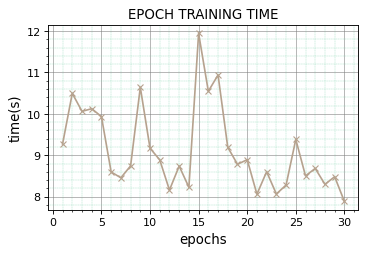

In [31]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, "x-", color='#B6A28E', label='ett')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the `MSE` loss of the model in each epoch.

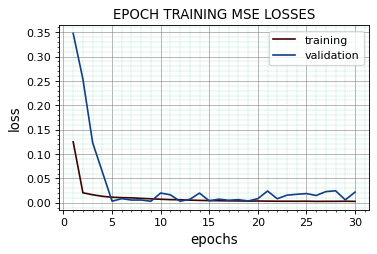

In [32]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color='#3D0301', label='training')
plt.plot(epochs, history.val_losses, color='#133E87', label='validation')
plt.title("EPOCH TRAINING MSE LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

In the next code cell we are going to evaluate our best model on the test data using the `MSE`.

In [33]:
model.load_state_dict(torch.load('best-model.pt'))
test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f}')

Test Loss: 0.007


Next let's make some predictions based on using our dataset.

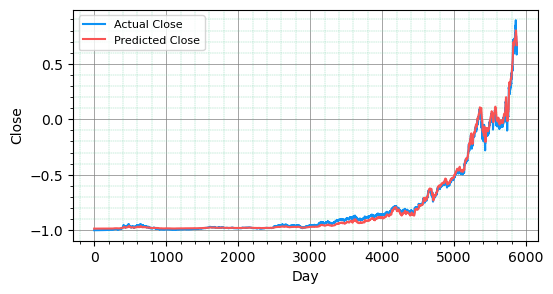

In [34]:
def predict(X, device):
    with torch.no_grad():
        predicted = model(X.to(device)).to('cpu').numpy()
    return predicted


predicted = predict(X_train, device)

plt.figure(figsize=(6, 3))
plt.plot(y_train.flatten(), label='Actual Close', color="#0D92F4")
plt.plot(predicted.flatten(), label='Predicted Close', color="#F95454")
plt.xlabel('Day', fontsize=10)
plt.ylabel('Close', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

In [35]:
def reverse_transform_and_return_y(X, y, lookback=7):
    y = y.flatten()
    dummies = np.zeros((X.shape[0], lookback+1))
    dummies[:, 0] = y
    dummies = scaler.inverse_transform(dummies)
    y = dc(dummies[:, 0])
    return y

train_true = reverse_transform_and_return_y(X_train, y_train)
train_preds = reverse_transform_and_return_y(X_train, predicted)

Next let's plot some predictions versus the actual values of the `Close` label based on the train dataset.

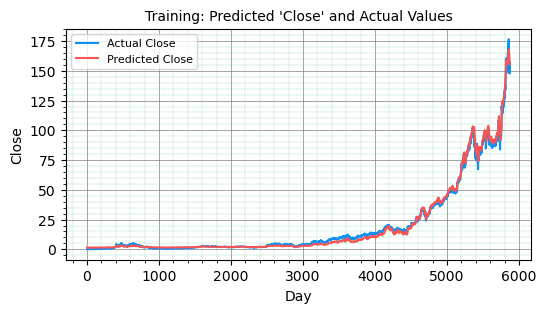

In [36]:

plt.figure(figsize=(6, 3))
plt.plot(train_true, label='Actual Close', color="#0D92F4")
plt.plot(train_preds, label='Predicted Close', color="#F95454")
plt.xlabel('Day', fontsize=10)
plt.ylabel('Close', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Training: Predicted 'Close' and Actual Values", fontsize=10)
plt.show()



Let's do the same on the validation dataset.

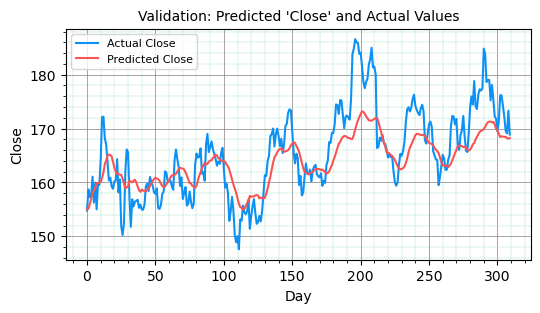

In [37]:

val_predicted = predict(X_val, device)
val_true = reverse_transform_and_return_y(X_val, y_val)
val_preds = reverse_transform_and_return_y(X_val, val_predicted)

plt.figure(figsize=(6, 3))
plt.plot(val_true, label='Actual Close', color="#0D92F4")
plt.plot(val_preds, label='Predicted Close', color="#F95454")
plt.xlabel('Day', fontsize=10)
plt.ylabel('Close', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Validation: Predicted 'Close' and Actual Values", fontsize=10)
plt.show()


Let's also do that for the test dataset.

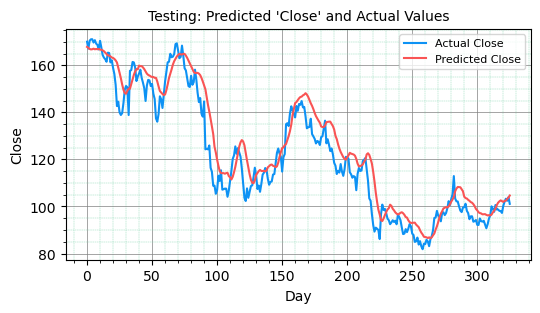

In [38]:
test_predicted = predict(X_test, device)
test_true = reverse_transform_and_return_y(X_test, y_test)
test_preds = reverse_transform_and_return_y(X_test, test_predicted)

plt.figure(figsize=(6, 3))
plt.plot(test_true, label='Actual Close', color="#0D92F4")
plt.plot(test_preds, label='Predicted Close', color="#F95454")
plt.xlabel('Day', fontsize=10)
plt.ylabel('Close', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Testing: Predicted 'Close' and Actual Values", fontsize=10)
plt.show()
